In [1]:
# # 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('F:/hk2 nam3/nhi/is403/IS403_O21_04/Dataset/NVL Historical Data 1_6.csv')
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df = df[::-1]
df1=df.reset_index()['Price']
df1

0       27815.0
1       28410.0
2       28707.0
3       28962.0
4       29556.0
         ...   
1593    14500.0
1594    14500.0
1595    14150.0
1596    14150.0
1597    14450.0
Name: Price, Length: 1598, dtype: float64

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
test_size

160

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)



In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
X_train.shape

(1337, 100, 1)

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 0.1041 - val_loss: 0.0082
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0075 - val_loss: 1.9095e-04
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0040 - val_loss: 5.2815e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0034 - val_loss: 2.6271e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - loss: 0.0030 - val_loss: 2.9176e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0021 - val_loss: 2.2908e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0017 - val_loss: 1.8881e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0017 - val_loss: 1.7885e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0021 - val_loss: 2.3236e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0020 - val_loss: 1.8273e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0016 - val_loss: 2.1873e-04
E

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 321ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [15]:
y_pred.shape

(59, 1)

In [16]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
test_mae = np.mean(np.abs(ytest - y_pred))


print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 16041.899742523072
Testing MAPE: 25222701.531543672
Testing MAE: 15987.16018076785


In [17]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[:100].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.08202143]
101
1 day input [0.04810268 0.05114716 0.05601832 0.05723611 0.05236495 0.04262263
 0.03348921 0.03592479 0.04323153 0.03775147 0.04140484 0.04384042
 0.03227142 0.03714258 0.03714258 0.03227142 0.034707   0.04566711
 0.05236495 0.05540942 0.05175605 0.06393395 0.07367626 0.07002289
 0.06697842 0.07124068 0.07306737 0.07915632 0.07124068 0.07245847
 0.07306737 0.08646305 0.08220079 0.08950753 0.08646305 0.08768084
 0.09559647 0.09072532 0.09072532 0.09620537 0.09681426 0.09803205
 0.08828974 0.08950753 0.08950753 0.09072532 0.08220079 0.07367626
 0.080983   0.07489405 0.07976521 0.07915632 0.07732963 0.07732963
 0.080983   0.080983   0.07976521 0.07854742 0.08280968 0.07915632
 0.07976521 0.0803741  0.0803741  0.08585416 0.08280968 0.080983
 0.0803741  0.07367626 0.07367626 0.07793853 0.07245847 0.07367626
 0.07489405 0.08585416 0.08220079 0.07854742 0.07732963 0.07732963
 0.07489405 0.07550295 0.07854742 0.07854742 0.08220079 0.08220079
 0.08524526 0.08585416 0.08828974 0

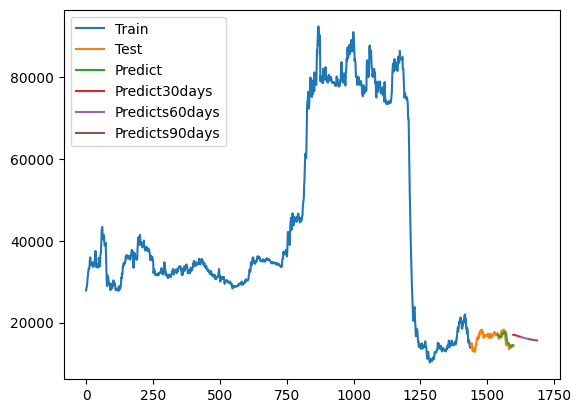

In [18]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output[0:30]))
predict_data_index_60 = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output[30:60]))
predict_data_index_90 = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output[60:90]))

plt.legend(['Train','Test','Predict','Predict30days', 'Predicts60days', 'Predicts90days'])
plt.savefig('Team4_LSTM_NVL_9_1.png')
plt.show()
